Import libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np

TensorFlow 2.x selected.


Define constants

In [0]:
DATE_COLUMN_NAME="Date"
VALUE_COLUMN_NAME="Sunspot Number"
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEPS=12

Prapere data

In [0]:
dataset=pd.read_csv("/content/Sunspots.csv")

In [4]:
dataset.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31 00:00:00,96.7
1,1,1749-02-28 00:00:00,104.3
2,2,1749-03-31 00:00:00,116.7
3,3,1749-04-30 00:00:00,92.8
4,4,1749-05-31 00:00:00,141.7


In [0]:
del dataset['Unnamed: 0']

In [0]:
dataset.columns=[DATE_COLUMN_NAME,VALUE_COLUMN_NAME]
dataset[DATE_COLUMN_NAME]=pd.to_datetime(dataset[DATE_COLUMN_NAME])

In [7]:
dataset.head()

,Date,Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Create charts

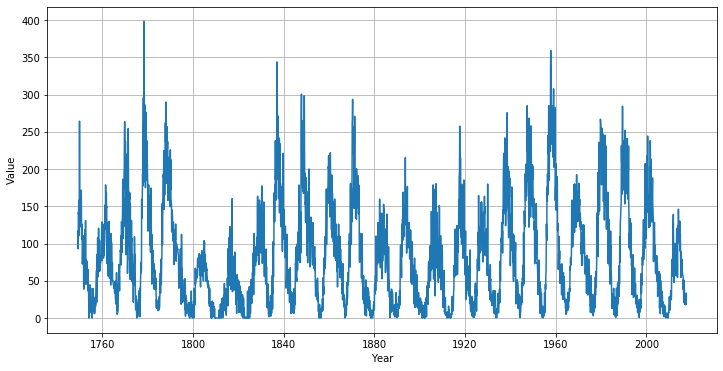

In [9]:
plt.figure(figsize=(12,6))
plt.plot(dataset[DATE_COLUMN_NAME], dataset[VALUE_COLUMN_NAME], "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

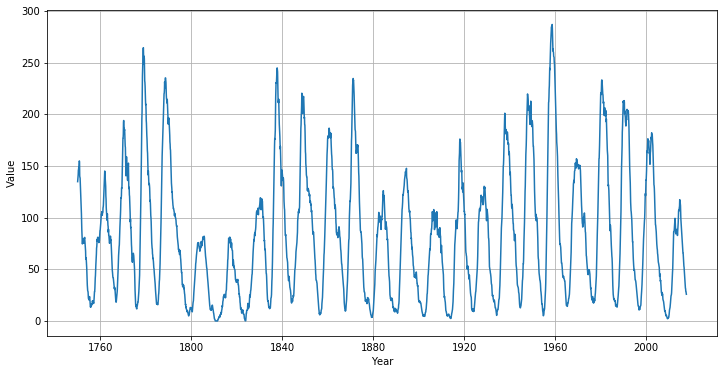

In [10]:
sunspot_number=dataset[VALUE_COLUMN_NAME]
trend=sunspot_number.rolling(12).mean()
plt.figure(figsize=(12,6))
plt.plot(dataset[DATE_COLUMN_NAME], trend, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

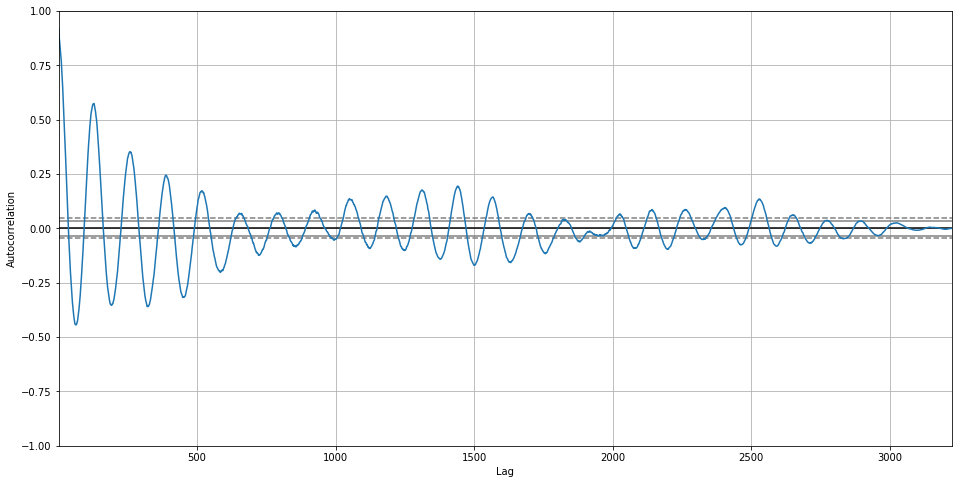

In [11]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(dataset[VALUE_COLUMN_NAME])

Split data

In [0]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, random_state=42, shuffle=False)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_dataset, validate_dataset = train_test_split(train_dataset, test_size=0.15, random_state=42, shuffle=False)
train_dataset = train_dataset.reset_index(drop=True)
validate_dataset = validate_dataset.reset_index(drop=True)

ARIMA model

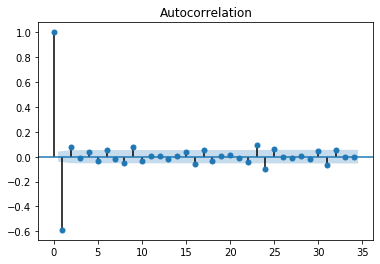

In [7]:
train_dataset_diff1=train_dataset[VALUE_COLUMN_NAME].diff().fillna(train_dataset[VALUE_COLUMN_NAME])
train_dataset_diff2=train_dataset_diff1.diff().fillna(train_dataset_diff1)
plot_acf(train_dataset_diff2)
plt.show()

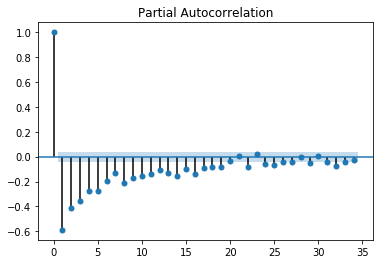

In [8]:
plot_pacf(train_dataset_diff2)
plt.show()

In [90]:
model = ARIMA(train_dataset[VALUE_COLUMN_NAME], (9,0,1), dates=train_dataset[DATE_COLUMN_NAME])
model_fit=model.fit()
predictions = model_fit.forecast(steps=len(test_dataset))[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


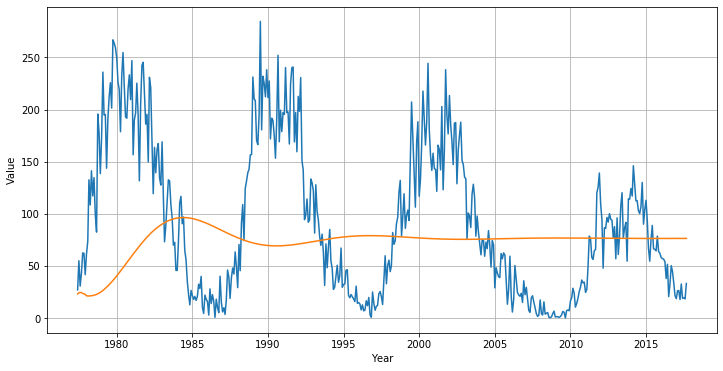

In [91]:
plt.figure(figsize=(12,6))
plt.plot(test_dataset[DATE_COLUMN_NAME], test_dataset[VALUE_COLUMN_NAME], "-",)
plt.plot(test_dataset[DATE_COLUMN_NAME], predictions, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

Neural network model

In [0]:
train_sunspot_number=train_dataset[VALUE_COLUMN_NAME]
validate_sunspot_number=validate_dataset[VALUE_COLUMN_NAME]

In [0]:
train_sunspot_number_mean=train_sunspot_number.mean()
train_sunspot_number_std=train_sunspot_number.std()
train_sunspot_number=(train_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std

validate_sunspot_number=(validate_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std

In [0]:
def univariate_data(dataset, history_size):
  data = []
  labels = []

  start_index = history_size
  end_index = len(dataset)

  for i in range(start_index, end_index):
    data.append(dataset[i-history_size:i])
    labels.append(dataset[i])

  x=np.array(data)
  y=np.array(labels)

  return x.reshape((x.shape[0],history_size,1)), y

In [0]:
x_train, y_train = univariate_data(train_sunspot_number, STEPS)
x_validate, y_validate = univariate_data(train_sunspot_number, STEPS)

In [0]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(optimizer='adam', loss='mae')

In [20]:
model.fit(train_data,epochs=10,validation_data=val_data, steps_per_epoch=100, validation_steps=30)

Train for 100 steps, validate for 30 steps
Epoch 1/10
100/100 [==============================] - 4s 42ms/step - loss: 0.5659 - val_loss: 0.3983
Epoch 2/10
100/100 [==============================] - 1s 14ms/step - loss: 0.3727 - val_loss: 0.3466
Epoch 3/10
100/100 [==============================] - 2s 15ms/step - loss: 0.3279 - val_loss: 0.3219
Epoch 4/10
100/100 [==============================] - 1s 14ms/step - loss: 0.3152 - val_loss: 0.3080
Epoch 5/10
100/100 [==============================] - 1s 14ms/step - loss: 0.3015 - val_loss: 0.3023
Epoch 6/10
100/100 [==============================] - 1s 14ms/step - loss: 0.2949 - val_loss: 0.2994
Epoch 7/10
100/100 [==============================] - 2s 15ms/step - loss: 0.2901 - val_loss: 0.2937
Epoch 8/10
100/100 [==============================] - 2s 15ms/step - loss: 0.2957 - val_loss: 0.2912
Epoch 9/10
100/100 [==============================] - 1s 15ms/step - loss: 0.2858 - val_loss: 0.2869
Epoch 10/10
100/100 [===========================

Prediction

In [0]:
predictions=model.predict(x_validate)

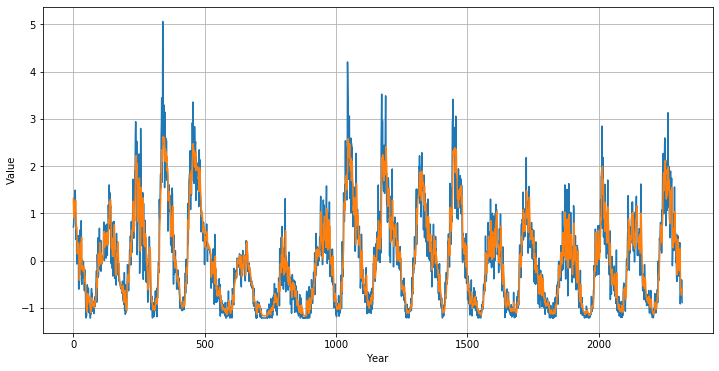

In [23]:
times=list(range(1,len(y_validate)+1))
plt.figure(figsize=(12,6))
plt.plot(times, y_validate, "-",)
plt.plot(times, predictions, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

In [31]:
model.evaluate(val_data,steps=STEPS)

12/12 [==============================] - 0s 5ms/step - loss: 0.2916


0.2916102620462577

In [0]:
test_sunspot_number=test_dataset[VALUE_COLUMN_NAME]
test_sunspot_number=(test_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std
x_test, y_test = univariate_data(test_sunspot_number, STEPS)

In [0]:
predictions=model.predict(x_test)

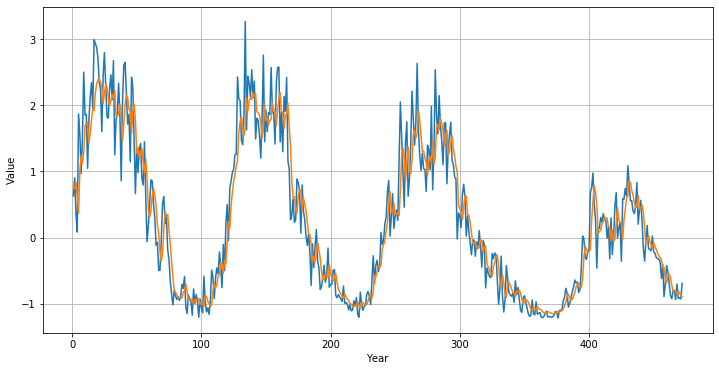

In [28]:
times=list(range(1,len(y_test)+1))
plt.figure(figsize=(12,6))
plt.plot(times, y_test, "-",)
plt.plot(times, predictions, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

In [0]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

In [39]:
model.evaluate(test_data,steps=STEPS)

12/12 [==============================] - 0s 4ms/step - loss: 0.2810


0.2809846103191376